## インポートとモデル準備

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

MODEL_NAME = "prosusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
labels = ['negative', 'neutral', 'positive']

## ニュースcsvの読み込み

In [ ]:
ticker = "BLK"
csv_path = f"../data/{ticker}_news_finnhub_20250518.csv"

df = pd.read_csv(csv_path)

# 感情分析対象のテキスト（headline + summary)
texts = df['headline'].fillna('') + '. ' + df['summary'].fillna('')

## 感情分析関数の定義

In [ ]:
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    return labels[pred]

## 分析実行

In [ ]:
df['sentiment_finbert'] = texts.apply(get_sentiment)

# 数値スコアに変換(positive=1, neutral=0, negative=-1)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['sentiment_finbert'].map(sentiment_map)

output_path = f"../data/{ticker}_news_with_sentiment.csv"
df.to_csv(output_path, index=False)

print(f"analysis completed {output_path}")

## FinBERT感情と株価の相関分析

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# 銘柄
ticker = "BLK"

# 過去30日の株価取得
end_date = datetime.today()
start_date = end_date - timedelta(days=30)
stock_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

# 株価データ
stock_df = stock_data[['Close']]
stock_df = stock_df.reset_index()
stock_df.columns = ['Date', 'Close']
stock_df['Date'] = stock_df['Date'].dt.strftime('%Y-%m-%d')

# 感情データ読み込み
sentiment_df = pd.read_csv(f"../data/{ticker}_news_with_sentiment.csv")
sentiment_df['date'] = pd.to_datetime(sentiment_df['datetime']).dt.strftime('%Y-%m-%d')
daily_sentiment = sentiment_df.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'Date', 'sentiment_score': 'SentimentScore'}, inplace=True)

# merge
merged_df = pd.merge(stock_df, daily_sentiment, on='Date', how='inner')

In [ ]:
print(merged_df.head())
correlation = merged_df[['Close', 'SentimentScore']].corr().iloc[0, 1]
print(f"相関係数: {correlation:.4f}")

## 可視化

In [ ]:
# 折れ線グラフ

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左Y軸：株価
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price (Close)', color=color)
ax1.plot(merged_df['Date'], merged_df['Close'], color=color, marker='o', label='Stock Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)

# 右Y軸：感情スコア
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(merged_df['Date'], merged_df['SentimentScore'], color=color, marker='x', linestyle='--', label='Sentiment Score')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'{ticker} Sentiment Score vs Stock Price')
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# 感情スコアvs株価の散布図
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(x='SentimentScore', y='Close', data=merged_df)
plt.title(f'{ticker} Sentiment Score vs Stock Price (Scatter)')
plt.xlabel('Sentiment Score')
plt.ylabel('Stock Price (Close)')
plt.grid(True)
plt.show()

## 翌日リターンとの相関分析

In [27]:
# 翌日の終値を取得（1日ずらす）
merged_df['NextClose'] = merged_df['Close'].shift(-1)
merged_df['NextReturn'] = (merged_df['NextClose'] - merged_df['Close']) / merged_df['Close']
filtered_df = merged_df.dropna(subset=['SentimentScore', 'NextReturn'])

# 相関係数を計算
correlation = filtered_df[['SentimentScore', 'NextReturn']].corr().iloc[0, 1]
print(f"感情スコアと翌日リターンの相関係数: {correlation:.4f}")

感情スコアと翌日リターンの相関係数: 0.2087


相関係数0.3以上でやや効果あり(?)レベル

## 感情スコアの移動平均vs株価トレンド（正規化したグラフ）

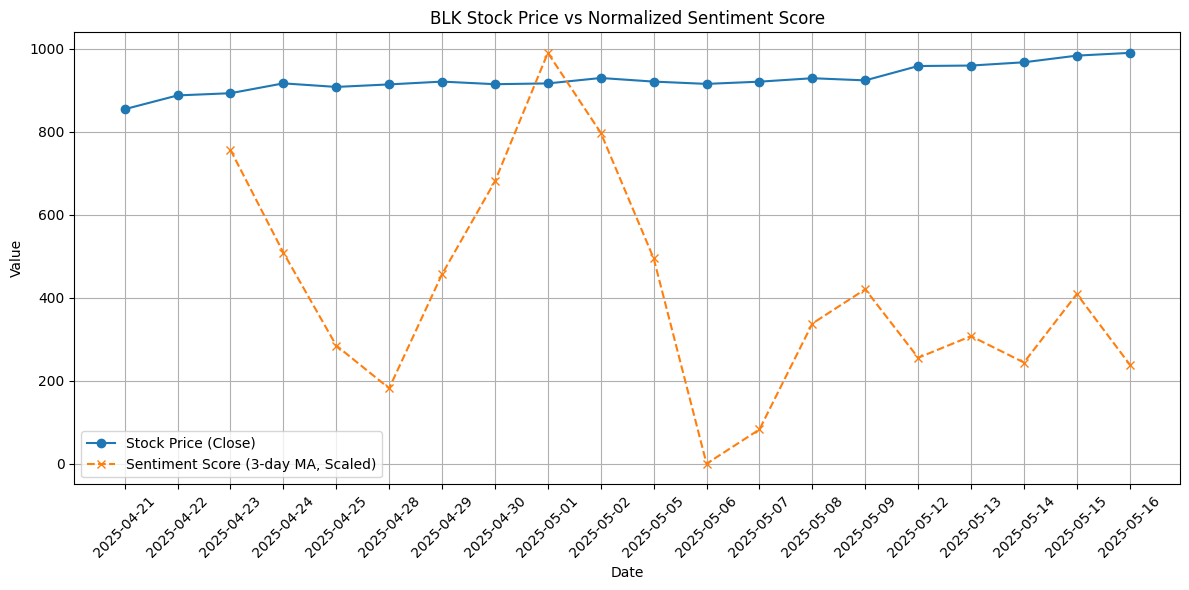

In [29]:
# 感情スコアの3日移動平均
merged_df['Sentiment_MA3'] = merged_df['SentimentScore'].rolling(window=3).mean()

# 正規化：0〜1の範囲にスケーリング
s_min = merged_df['Sentiment_MA3'].min()
s_max = merged_df['Sentiment_MA3'].max()
merged_df['Sentiment_MA3_norm'] = (merged_df['Sentiment_MA3'] - s_min) / (s_max - s_min)

# 折れ線グラフ
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['Close'], label='Stock Price (Close)', marker='o')
plt.plot(merged_df['Date'], merged_df['Sentiment_MA3_norm'] * merged_df['Close'].max(), 
         label='Sentiment Score (3-day MA, Scaled)', linestyle='--', marker='x')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'{ticker} Stock Price vs Normalized Sentiment Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 仮説
FinBERT感情スコアがポジティブ（> 0）だった日は、翌日のリターンがプラスである傾向があるはず？

In [30]:
# 前提：NextReturn（翌日リターン）と SentimentScore がすでにある merged_df

# ポジティブな感情スコア (>0)
positive_days = merged_df[merged_df['SentimentScore'] > 0]

# ネガティブな感情スコア (<0)
negative_days = merged_df[merged_df['SentimentScore'] < 0]

# 平均リターンの比較
avg_return_positive = positive_days['NextReturn'].mean()
avg_return_negative = negative_days['NextReturn'].mean()

print(f"▶ 平均リターン (ポジティブ感情): {avg_return_positive:.4%}")
print(f"▶ 平均リターン (ネガティブ感情): {avg_return_negative:.4%}")

▶ 平均リターン (ポジティブ感情): 0.8119%
▶ 平均リターン (ネガティブ感情): 0.5770%


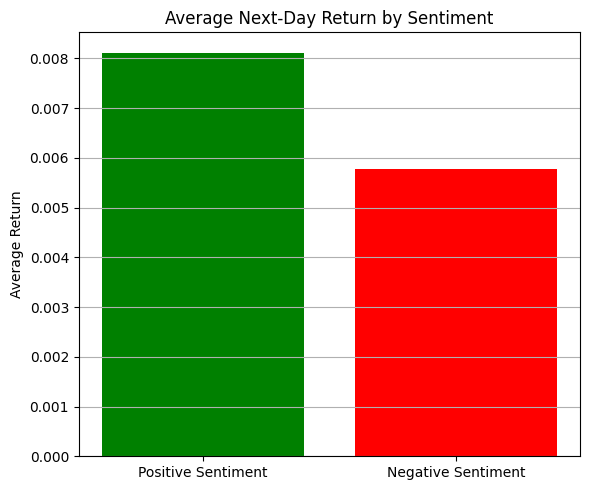

In [31]:
import matplotlib.pyplot as plt

labels = ['Positive Sentiment', 'Negative Sentiment']
values = [avg_return_positive, avg_return_negative]

plt.figure(figsize=(6, 5))
plt.bar(labels, values, color=['green', 'red'])
plt.title('Average Next-Day Return by Sentiment')
plt.ylabel('Average Return')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### 有意な差があるのか（t検定）
2つのグループ（positive, negative）の母平均が等しいかをWelchのt検定

In [32]:
from scipy.stats import ttest_ind

# リターンデータ
returns_pos = positive_days['NextReturn'].dropna()
returns_neg = negative_days['NextReturn'].dropna()

# Welchのt検定(等分散を仮定しない)
t_stat, p_value = ttest_ind(returns_pos, returns_neg, equal_var=False)

print(f"t統計量: {t_stat:.4f}")
print(f"p値: {p_value:.4f}")

# 有意水準5%
if p_value < 0.05:
    print("有意な差あり")
else:
    print("有意な差なし")

t統計量: 0.3851
p値: 0.7104
有意な差なし
